## 1. Setup & imports

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

Project root: /shared/crollo/faers-radar


In [3]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from faers_signals.config import WAREHOUSE_DB_PATH
from faers_signals.emergence import (
    EmergenceConfig,
    compute_emergence_scores_for_drug,
    compute_global_emergence_scores,
)

# Optional: nicer plots
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

con = duckdb.connect(str(WAREHOUSE_DB_PATH))
print("Connected to:", WAREHOUSE_DB_PATH)

Connected to: /shared/crollo/faers-radar/data/warehouse/faers_2019_present.duckdb


## 2. Per-drug temporal signals & emergence/slope

### 2.1 Choose a drug and pull its time series

In [4]:
drug = "ATORVASTATIN"  # can change to any drugname_norm

signals_q = con.execute("""
    SELECT *
    FROM signals_quarterly
    WHERE drugname_norm = ?
    ORDER BY pt, year, quarter_idx
""", [drug]).fetchdf()

signals_q.head()


,drugname_norm,pt,year,quarter,quarter_idx,total_reports,total_drug_reports,total_event_reports,n11,n10,n01,n00,ror,ror_ci_low,ror_ci_high,prr
0,ATORVASTATIN,AST/ALT ratio abnormal,2020,Q1,8081,384326,940,7,3,937,4,383382,318.065481,78.563115,1287.699080,316.886173
1,ATORVASTATIN,Abdominal adhesions,2019,Q4,8080,351969,793,34,3,790,31,351145,49.356315,16.322227,149.247149,49.143157
2,ATORVASTATIN,Abdominal adhesions,2020,Q1,8081,384326,940,43,3,937,40,383346,35.337291,11.835033,105.510828,35.209575
3,ATORVASTATIN,Abdominal discomfort,2019,Q1,8077,339887,765,2924,9,756,2915,336207,1.448135,0.762884,2.748904,1.442577
4,ATORVASTATIN,Abdominal discomfort,2019,Q2,8078,356922,652,2831,5,647,2826,353444,1.062173,0.458503,2.460639,1.061649


### 2.2 Compute emergence_z + slope_log_ror for this drug

In [5]:
cfg = EmergenceConfig(
    min_points=4,      # min quarters per PT
    min_n11_latest=5,  # min joint counts in latest quarter
)

emergence_drug = compute_emergence_scores_for_drug(drug, cfg=cfg, con=con)
emergence_drug.head(20)

,pt,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,Spinal stenosis,4.403801,0.427500,24.455520,11.059970,6,5
1,Anosmia,3.953809,0.612097,8.377131,4.383118,9,4
2,Diabetic ketoacidosis,3.205833,0.209939,9.657188,5.594073,13,9
3,Cardiac failure acute,2.854421,0.565851,31.625358,15.014293,7,7
4,Therapeutic product effect incomplete,2.757224,0.487545,3.361093,2.343964,30,25
5,Coeliac disease,2.447010,-0.058976,32.246496,20.310229,20,4
6,Parkinson's disease,2.384886,0.138819,15.824337,10.204345,21,6
7,Nephropathy,2.278262,0.598239,9.998109,4.261118,5,7
8,White blood cell count increased,2.012866,1.018747,7.688998,4.623634,15,10
9,"Hallucination, visual",1.943422,0.507254,11.459382,7.252016,19,9


### 2.3 Filter to strong & interesting PTs

In [6]:
strong_emergent = emergence_drug[
    (emergence_drug["latest_ror"] >= 2.0) &
    (emergence_drug["latest_ror_ci_low"] > 1.0) &
    (emergence_drug["latest_n11"] >= 10) &
    (emergence_drug["slope_log_ror"] > 0) &
    (emergence_drug["emergence_z"] > 0)
].copy()

strong_emergent.sort_values("emergence_z", ascending=False).head(20)

,pt,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
2,Diabetic ketoacidosis,3.205833,0.209939,9.657188,5.594073,13,9
4,Therapeutic product effect incomplete,2.757224,0.487545,3.361093,2.343964,30,25
6,Parkinson's disease,2.384886,0.138819,15.824337,10.204345,21,6
8,White blood cell count increased,2.012866,1.018747,7.688998,4.623634,15,10
9,"Hallucination, visual",1.943422,0.507254,11.459382,7.252016,19,9
12,White blood cell count decreased,1.847593,0.151237,2.195612,1.327932,15,9
15,Ischaemic stroke,1.723079,0.873529,25.722934,17.081915,25,16
19,Drug reaction with eosinophilia and systemic s...,1.565530,0.205663,13.386813,9.380289,32,24
20,Arthritis,1.563902,0.477432,4.633761,3.313550,35,18
27,Haemodynamic instability,1.394454,0.054385,24.028550,13.720556,13,5


## 3. Visualize time series for a single PT

In [7]:
if not strong_emergent.empty:
    pt = strong_emergent.iloc[0]["pt"]
else:
    # fallback: most supported PT
    pt = emergence_drug.sort_values("latest_n11", ascending=False).iloc[0]["pt"]

pt

'Diabetic ketoacidosis'

In [8]:
# 3.2 Get the full quarterly time series for (drug, pt)

ts = con.execute("""
    SELECT *
    FROM signals_quarterly
    WHERE drugname_norm = ?
      AND pt = ?
    ORDER BY quarter_idx
""", [drug, pt]).fetchdf()

ts[["year", "quarter", "n11", "ror", "ror_ci_low", "ror_ci_high"]].head()


,year,quarter,n11,ror,ror_ci_low,ror_ci_high
0,2020,Q4,3,4.157220,1.447834,11.936777
1,2021,Q2,3,4.593749,1.600389,13.185877
2,2021,Q3,5,7.348486,3.158506,17.096768
3,2021,Q4,4,4.351746,1.714874,11.043202
4,2022,Q2,3,3.664742,1.276870,10.518167


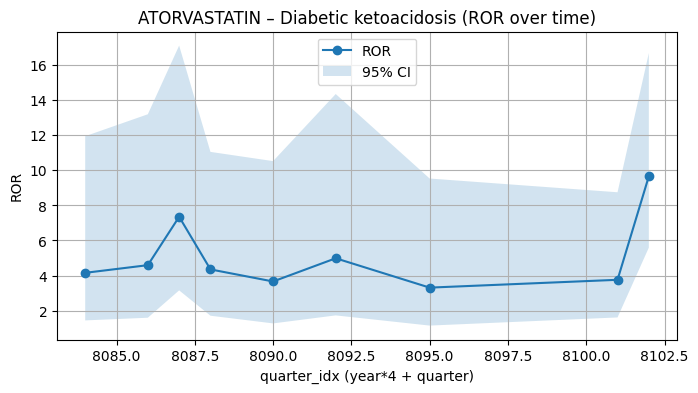

In [9]:
# 3.3 Plot ROR over time with CI bands

fig, ax = plt.subplots()

ax.plot(ts["quarter_idx"], ts["ror"], marker="o", label="ROR")

ax.fill_between(
    ts["quarter_idx"],
    ts["ror_ci_low"],
    ts["ror_ci_high"],
    alpha=0.2,
    label="95% CI"
)

ax.set_title(f"{drug} – {pt} (ROR over time)")
ax.set_xlabel("quarter_idx (year*4 + quarter)")
ax.set_ylabel("ROR")
ax.legend()
plt.show()


## 4. Global emergence ranking (all drugs)

### 4.1 Compute global scores (may take time!)

In [10]:
# This may take some time depending on min_total_drug_reports and max_drugs.

cfg = EmergenceConfig(
    min_points=4,
    min_n11_latest=5,
)

global_emergence = compute_global_emergence_scores(
    cfg=cfg,
    min_total_drug_reports=500,  # only consider drugs with >= 500 reports
    max_drugs=None,
    con=con,
)

global_emergence.head(20)


[info] Computing global emergence for 3985 drugs (min_total_drug_reports=500)
[info] [1/3985] DUPIXENT (n_reports=364758)
[info] [2/3985] ZANTAC (n_reports=325161)
[info] [3/3985] PREDNISONE (n_reports=291409)
[info] [4/3985] HUMIRA (n_reports=277769)
[info] [5/3985] METHOTREXATE (n_reports=203080)
[info] [6/3985] ASPIRIN (n_reports=202115)
[info] [7/3985] REVLIMID (n_reports=192365)
[info] [8/3985] DEXAMETHASONE (n_reports=169924)
[info] [9/3985] OMEPRAZOLE (n_reports=164992)
[info] [10/3985] ATORVASTATIN (n_reports=161809)
[info] [11/3985] ACETAMINOPHEN (n_reports=161668)
[info] [12/3985] GABAPENTIN (n_reports=161385)
[info] [13/3985] RANITIDINE (n_reports=159490)
[info] [14/3985] METFORMIN (n_reports=149996)
[info] [15/3985] PROACTIV MD ADAPALENE ACNE TREATMENT (n_reports=149530)
[info] [16/3985] ELIQUIS (n_reports=146119)
[info] [17/3985] AMLODIPINE (n_reports=144950)
[info] [18/3985] FUROSEMIDE (n_reports=132868)
[info] [19/3985] PANTOPRAZOLE (n_reports=126032)
[info] [20/3985] EN

,drugname_norm,pt,signal_score,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
0,EUMOVATE,Pyrexia,1259.480377,93.432873,2.338708,3.175851e+02,53.792267,6,4
1,TRIMETAZIDINE,Left ventricular hypertrophy,985.904996,48.736033,1.862860,5.201826e+04,8904.212478,8,4
2,DOXIL,Acute myeloid leukaemia,759.527772,35.924692,3.332449,5.682665e+02,211.215537,5,4
3,PROMETHAZINE,Suspected suicide,733.825938,14.712282,5.108680,1.738589e+04,3939.917413,6,4
4,CLOZAPINE,Investigation noncompliance,708.321371,59.486525,1.362013,6.261905e+03,375.520079,16,4
5,TRIMETAZIDINE,Pulmonary valve disease,674.495534,19.546610,2.273648,3.901789e+06,148217.559804,8,4
6,MEPOLIZUMAB,Mycobacterium avium complex infection,477.583693,79.113968,1.035764,3.387513e+02,154.950946,8,4
7,COUMADIN,Sopor,471.610709,15.576601,4.319534,1.105869e+03,421.173108,5,6
8,AZITHROMYCIN ANHYDROUS,Deafness neurosensory,465.769039,17.867825,3.724746,1.093942e+03,456.114213,6,4
9,RELYVRIO,Abdominal discomfort,455.449565,11.322415,5.488734,1.522453e+03,85.742695,6,6


In [21]:
global_emergence.to_csv("global_emergence.csv")

### 4.2 Apply classical strength filters

In [18]:

global_filtered = global_emergence[
    (global_emergence["latest_ror"] >= 2.0) &
    (global_emergence["latest_ror_ci_low"] > 1.0) &
    (global_emergence["latest_n11"] >= 10) &
    (global_emergence["n_points"] >= 5)
].copy()

global_filtered.head(20)

,drugname_norm,pt,signal_score,emergence_z,slope_log_ror,latest_ror,latest_ror_ci_low,latest_n11,n_points
11,ROXICODONE,Injury,368.622606,11.238662,4.341714,1908.327909,1415.717839,221,6
17,AFINITOR,Metastases to central nervous system,307.460563,17.021129,3.345290,220.333352,120.746996,13,6
44,COMIRNATY,Vertigo,199.240842,11.644833,3.301584,177.092317,121.140062,39,5
50,EMEND,Hepatocellular injury,191.578727,13.052920,2.505902,348.674954,178.520208,10,5
52,OXYCONTIN,Septic shock,186.436753,15.313087,3.596068,28.536925,16.029925,12,5
58,INDAPAMIDE,White blood cell count decreased,172.181492,13.373686,2.896996,84.126373,50.236082,20,5
62,OMEPRAZOLE,Hyperparathyroidism,165.844835,10.937535,2.594924,343.913917,194.946448,21,5
65,SOTROVIMAB,Foetal exposure during pregnancy,163.059744,3.751545,6.556840,755.655717,279.874525,13,5
70,ZEPATIER,Headache,156.284264,9.797044,3.468564,98.392388,33.080410,11,6
79,LATUDA,Urinary retention,147.930090,4.806983,4.827645,585.713047,394.216566,47,5


## 5. Helper cell: drill down on any row from global ranking

drugname_norm         ROXICODONE
pt                        Injury
signal_score          368.622606
emergence_z            11.238662
slope_log_ror           4.341714
latest_ror           1908.327909
latest_ror_ci_low    1415.717839
latest_n11                   221
n_points                       6
Name: 11, dtype: object

,year,quarter,n11,ror,ror_ci_low,ror_ci_high
0,2020,Q3,3,12.554926,4.307239,36.595645
1,2020,Q4,10,10.732728,5.767139,19.973759
2,2021,Q1,7,11.849238,5.710726,24.586093
3,2021,Q2,9,4.560283,2.394939,8.683387
4,2021,Q4,5,5.211870,2.242840,12.111245


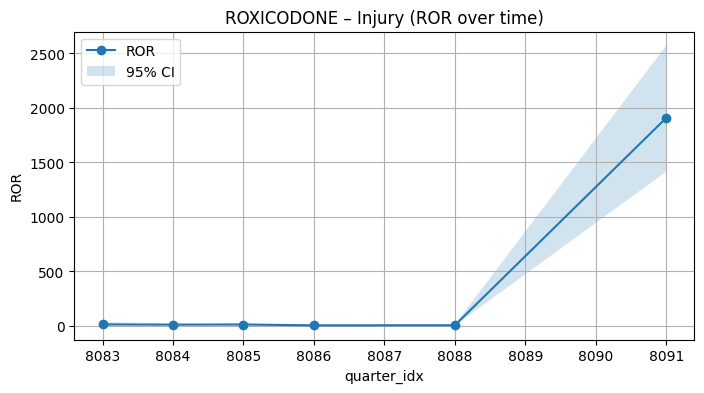

In [19]:
# 5. Drill-down helper: choose one row from the global table and inspect its time series

row_idx = 0  # change to inspect different rows

if not global_filtered.empty:
    row = global_filtered.iloc[row_idx]
    display(row)

    drug_g = row["drugname_norm"]
    pt_g = row["pt"]

    ts_g = con.execute("""
        SELECT *
        FROM signals_quarterly
        WHERE drugname_norm = ?
          AND pt = ?
        ORDER BY quarter_idx
    """, [drug_g, pt_g]).fetchdf()

    display(ts_g[["year", "quarter", "n11", "ror", "ror_ci_low", "ror_ci_high"]].head())

    fig, ax = plt.subplots()
    ax.plot(ts_g["quarter_idx"], ts_g["ror"], marker="o", label="ROR")
    ax.fill_between(
        ts_g["quarter_idx"],
        ts_g["ror_ci_low"],
        ts_g["ror_ci_high"],
        alpha=0.2,
        label="95% CI"
    )
    ax.set_title(f"{drug_g} – {pt_g} (ROR over time)")
    ax.set_xlabel("quarter_idx")
    ax.set_ylabel("ROR")
    ax.legend()
    plt.show()
else:
    print("global_filtered is empty; adjust filters or config.")
